In [2]:
import sys

sys.path.append("..")

from tools.display_tools import plot_current_state_of_graph
import pickle
import numpy as np
from IPython.display import HTML
import pandas as pd


from wetterdienst.provider.dwd.observation import (
    DwdObservationDataset,
    DwdObservationRequest,
    DwdObservationResolution,
)
import datetime


from datetime import datetime

### Script how to select a time interval with specific weather conditions.

In [3]:
# Load graph base and extract measurement station coordinates from the graph.
G = pickle.load(open("../resources/flood_G.p", "rb"))
bb_box = np.array(list(np.array([G.nodes[x]["p"] for x in G.nodes]).max(axis=0)) + list(np.array([G.nodes[x]["p"] for x in G.nodes]).min(axis=0)))

In [4]:
# somehow most stations only go until 2023. Select window from here.
requests = DwdObservationRequest(
    parameter=DwdObservationDataset.PRECIPITATION_MORE,
    resolution=DwdObservationResolution.DAILY,
    start_date=datetime(2019, 1, 1),
    end_date=datetime(2023, 1, 1),
    
)

In [5]:
# Filter my location
res = requests.filter_by_bbox(bb_box[3],bb_box[2],bb_box[1],bb_box[0]-0.2).df

# Filter by time
c1 = res["end_date"].dt.year() > 2022
c2 = res["start_date"].dt.year() < 2019

selection = []
for n in range(len(c1)):
    if c1[n] and c2[n]: 
        selection.append(n)
res = res[selection]

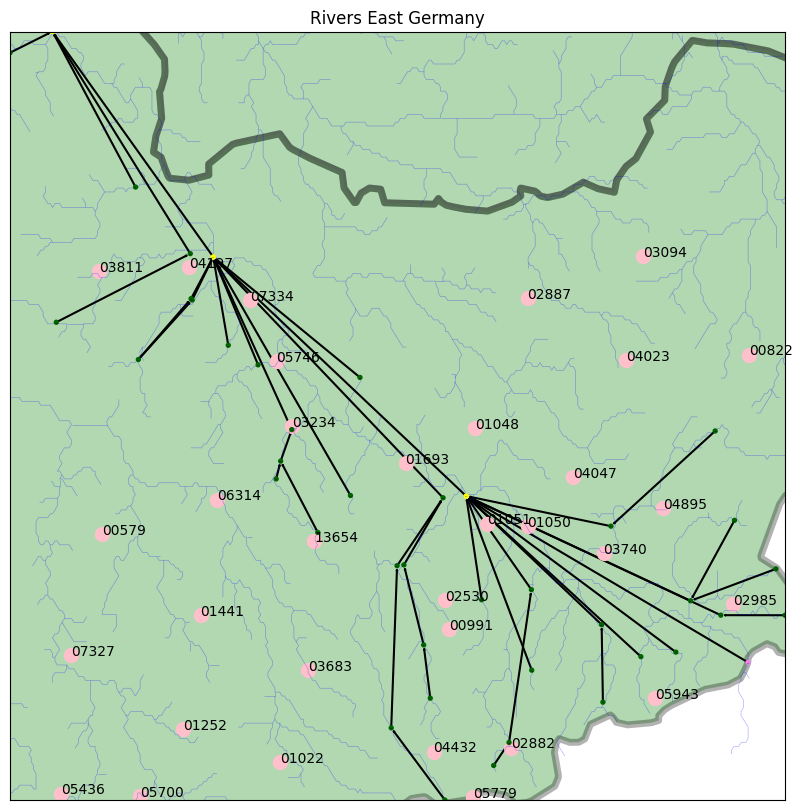

In [6]:
# Full Graph
plot_current_state_of_graph(
    G,
    lim=(bb_box[2], bb_box[0]),
    limx=(bb_box[3], bb_box[1]),
    dpi=50,
    node_size=8,
    save=0,
    river_map=True,
    ger_map=True,
    width=1.5,
    arrowsize=1,
    fs=(10, 10),
    font_size=1,
    extra_points=res[["longitude", "latitude", "station_id"]].to_numpy(),
    ger_path = "../visualization/east_german_map.shp",
    river_path = "../visualization/river_east_german_map.shp",
)

In [7]:
# We now remove stations that are too far away from the actual stations. As these are few, we do it by hand.
remove =["02887","04023", "03094", "00822", "03683", "01022", "01252", "01441", "00579", "07327", "05436", "05700", "01022", "06314"]
selection = []
for n,x in enumerate((res["station_id"])):
    if x not in remove:
        selection.append(n)
res = res[selection]

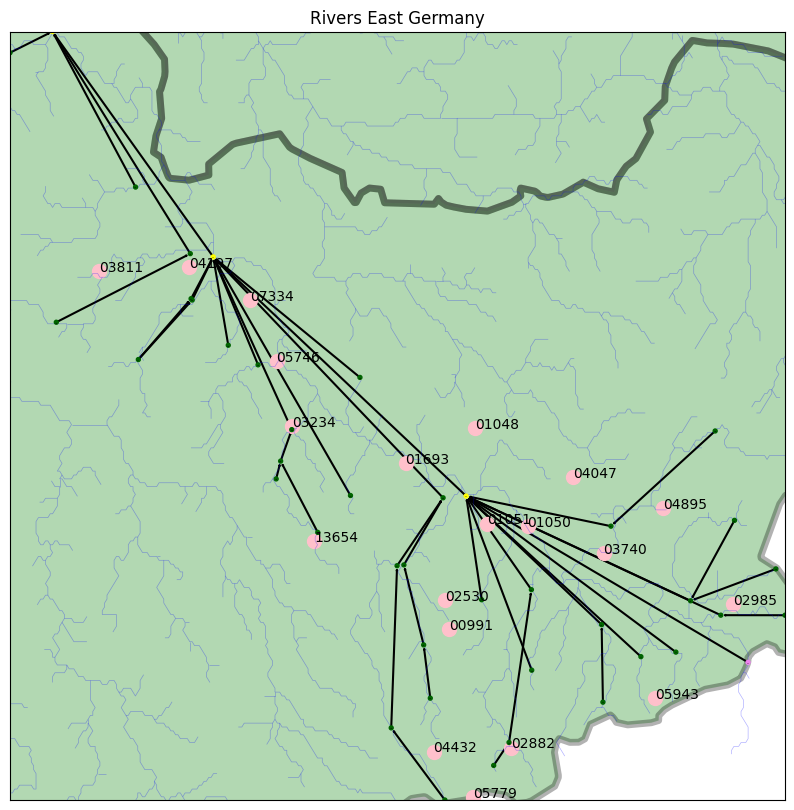

In [8]:
# Full Graph
plot_current_state_of_graph(
    G,
    lim=(bb_box[2], bb_box[0]),
    limx=(bb_box[3], bb_box[1]),
    dpi=50,
    node_size=8,
    save=0,
    river_map=True,
    ger_map=True,
    width=1.5,
    arrowsize=1,
    fs=(10, 10),
    font_size=1,
    extra_points=res[["longitude", "latitude", "station_id"]].to_numpy(),
    ger_path = "../visualization/east_german_map.shp",
    river_path = "../visualization/river_east_german_map.shp",
)

In [9]:
# Get the data from the selected stations.
stations = requests.filter_by_station_id(station_id=res["station_id"])

In [10]:
#query the data and concat everything into a table
data = []
for result in stations.values.query():
    data.append(result.df[list(np.where(result.df["parameter"] == "precipitation_height")[0])])

stack = []
for x in data:
    name = x["station_id"][0]
    df = x["date", "value"].to_pandas()
    df.index = df.date.values
    df.drop(columns="date", inplace=True)
    df.columns = [name]
    stack.append(df)
prec = pd.concat(stack,axis=1)

/home/stein/anaconda3/envs/rivers1k/lib/python3.10/site-packages/wetterdienst/provider/dwd/observation/parser.py:151: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  df = df.drop(col for col in DROPPABLE_PARAMETERS if col in df.columns)


In [16]:
prec

,00991,01048,01050,01051,01693,02530,02882,02985,03234,03740,03811,04047,04197,04432,04895,05746,05779,05943,07334,13654
2019-01-01,2.8,0.9,3.0,1.1,3.0,2.1,7.3,5.4,1.3,4.8,5.7,2.8,1.3,5.5,4.3,4.3,9.2,1.3,0.9,3.4
2019-01-02,1.3,0.3,0.4,1.0,1.1,1.5,3.3,1.7,1.1,0.3,0.0,0.1,0.2,3.3,2.4,1.4,2.8,0.6,1.0,1.0
2019-01-03,0.9,0.1,0.3,0.2,0.9,1.4,2.6,1.0,1.1,0.6,0.3,0.9,0.2,3.3,1.9,0.7,6.5,1.0,0.1,1.3
2019-01-04,4.1,3.4,6.5,2.6,1.6,4.1,4.7,4.5,4.0,8.1,4.3,2.5,5.1,7.5,8.4,4.0,13.7,4.7,3.3,6.1
2019-01-05,11.3,5.3,7.9,7.3,4.1,12.1,11.8,7.5,6.9,5.7,3.2,3.5,5.0,15.1,8.2,4.4,22.6,11.5,4.1,10.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,0.6,0.3,0.0,0.0,0.1,0.0,0.4,0.2,0.2,0.2,0.2,0.8,0.5,2.3,1.5,0.0,0.6,0.0,0.2,0.5
2022-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-30,1.1,0.3,0.2,0.3,0.0,0.2,0.9,1.0,0.3,0.4,0.7,1.3,0.4,1.2,2.0,0.5,1.0,0.1,0.2,1.0
2022-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Calculate the sum of all stations and over a rolling window to find intervals with, in this case, low precipitation.
prec_sum = prec.sum(axis=1,skipna=False)
result = prec_sum.rolling(30,min_periods=30).mean()
mini = result.nsmallest(200)

In [17]:
# Check the ones that represents full months.
mini[mini.index.day == 30]

2020-04-30     3.433333
2020-11-30     5.913333
2021-10-30     9.826667
2022-03-30    10.390000
2020-12-30    14.340000
2022-07-30    14.510000
2020-01-30    14.713333
2022-10-30    16.073333
dtype: float64

In [18]:
# Candidate set: Oktober 2021, as periods with lower precipitation have too much missing data.
index = np.where(result.index == "2021-10-30")[0][0]
prec.iloc[index-29: index].sum(axis=1).mean()

In [29]:
# We have to prevent selecting an interval with many missing values.
data = pd.read_csv("../resources/rivers_ts_east_germany.csv", index_col=0, )
data = data[[str(x) for x in list(G.nodes)]]

c1 = pd.to_datetime(data.index).year == 2021
c2 = pd.to_datetime(data.index).month == 10

# seems reasonable.

### This is the subselection we take: 10, 2020. 
### One month of data with basically no rain (We evaluate this subsection in experiment set 2)